In [26]:
print("""
@Title: Python 金融分析概述
@Author(s): Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime: 2023-09-29 20:58:20
@Description: 
""")


@Title: Python 金融分析概述
@Author(s): Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime: 2023-09-29 20:58:20
@Description: 



# Python 金融分析概述

## 绘制时间序列图

### 从 quandl 检索数据集

In [27]:
import quandl
with open('token.txt', 'r') as f:
    QUANDL_API_KEY = f.read()
    quandl.ApiConfig.api_key = QUANDL_API_KEY

In [28]:
df = quandl.get("EURONEXT/ABN")

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

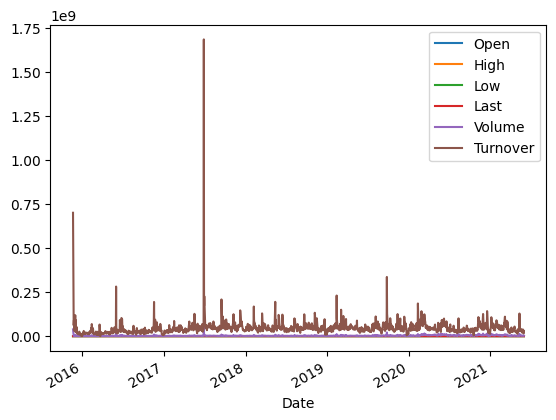

In [30]:
df.plot();

### 绘制收盘价与成交量的关系图

In [31]:
prices = df["Last"]
volumes = df["Volume"]

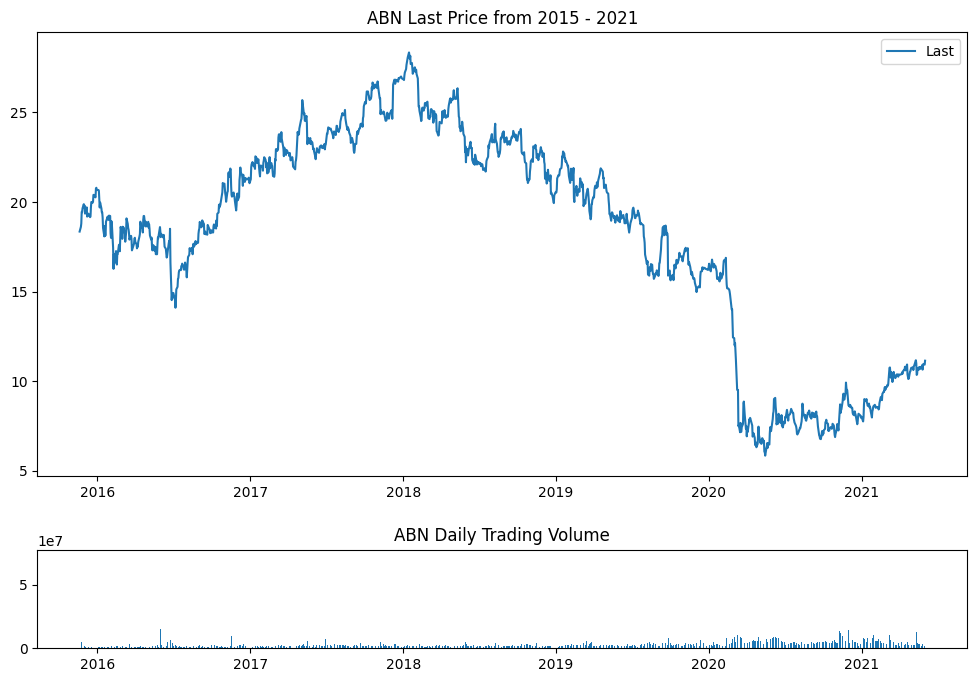

In [32]:
top = plt.subplot2grid((4, 4), (0, 0), rowspan=3, colspan=4)
top.plot(prices.index, prices, label="Last")
plt.title("ABN Last Price from 2015 - 2021")
plt.legend()
bottom = plt.subplot2grid((4, 4), (3, 0), rowspan=1, colspan=4)
bottom.bar(volumes.index, volumes)
plt.title("ABN Daily Trading Volume")
plt.gcf().set_size_inches(12, 8)
plt.subplots_adjust(hspace=.75)

In [33]:
prices[-1:]

Date
2021-06-01    11.142
Name: Last, dtype: float64

### 绘制烛台图

In [34]:
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates

In [35]:
df_subset = quandl.get("EURONEXT/ABN",
                       start_date="2018-07-01",
                       end_date="2018-07-31")
df_subset["Date"] = df_subset.index.map(mdates.date2num)

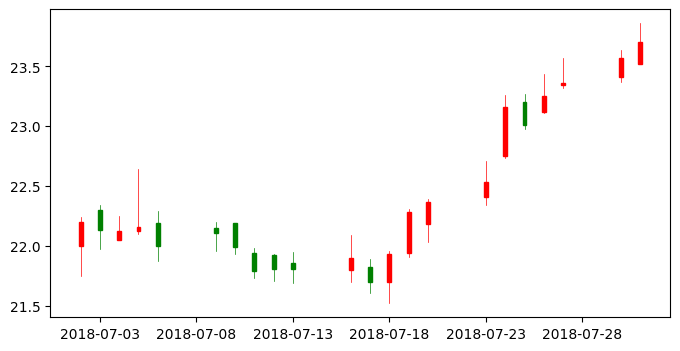

In [36]:
df_ohlc = df_subset[["Date", "Open", "High", "Low", "Last"]]
figure, ax = plt.subplots(figsize=(8, 4))
formatter = mdates.DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(formatter)
candlestick_ohlc(ax,
                 df_ohlc.values,
                 colorup="red",
                 colordown="green")
plt.show()

## 对时间序列数据进行金融分析

### 绘制收益率图

In [37]:
df = quandl.get("EURONEXT/ABN.4")
# df = quandl.get("EURONEXT/ABN", column_index=4)
# 股票代码的后缀设为 4，指定仅检索数据集的第四列，即收盘价格
daily_changes = df.pct_change(periods=1)

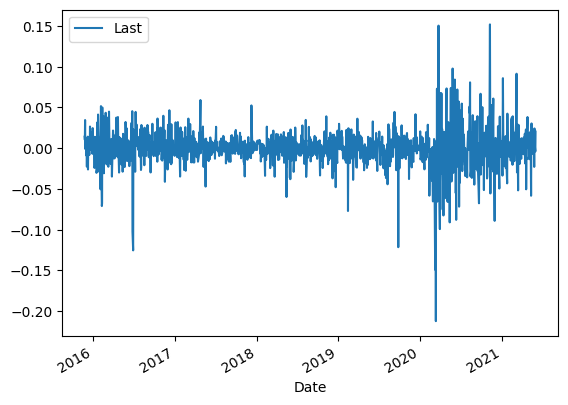

In [38]:
daily_changes.plot();

### 绘制乐基收益率图

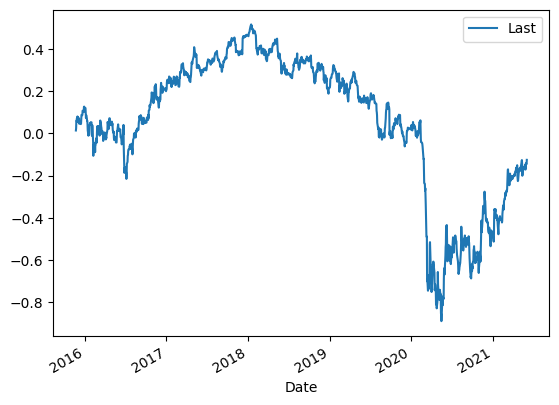

In [39]:
df_cumsum = daily_changes.cumsum()
df_cumsum.plot();

### 绘制直方图

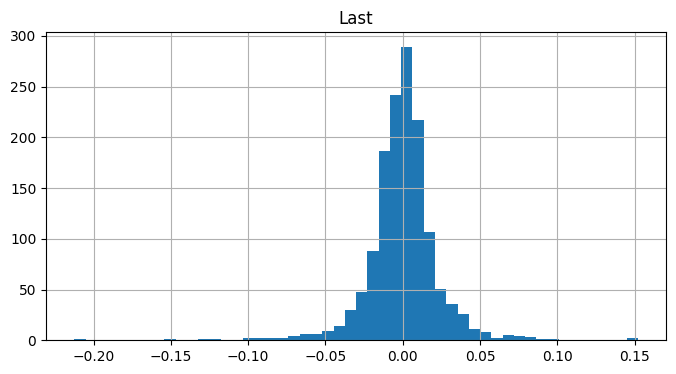

In [40]:
daily_changes.hist(bins=50, figsize=(8, 4))
plt.show()
# 当 DataFrame 中存在多个数据列时，hist() 命令将自动在每个单独的绘图单元上绘制所有直方图

In [41]:
daily_changes.describe()

,Last
count,1408.000000
mean,-0.000089
std,0.022877
min,-0.212453
25%,-0.009574
50%,0.000283
75%,0.009749
max,0.152042


### 绘制波动率图

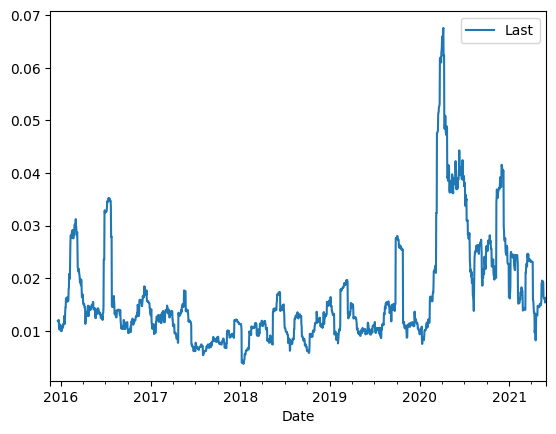

In [42]:
df_filled = df.asfreq("D", method="ffill")
df_returns = df_filled.pct_change()
# 前 29 行的数据不足，将会被排除掉
df_std = df_returns.rolling(window=30, min_periods=30).std()
df_std.plot();

### Q-Q 图

In [43]:
from scipy import stats
from scipy.stats import probplot

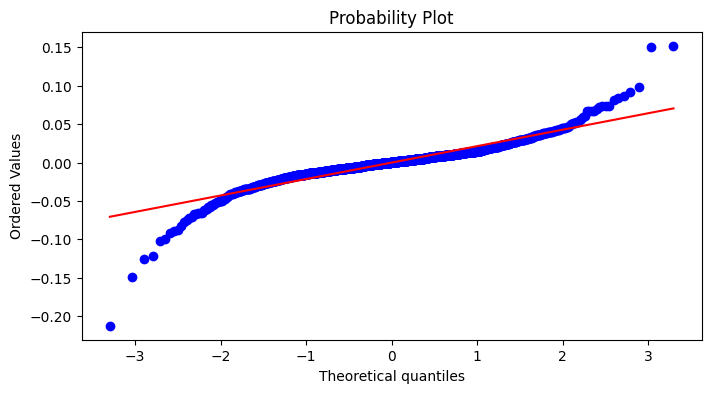

In [44]:
daily_changes = df.pct_change(periods=1).dropna()
figure = plt.figure(figsize=(8, 4))
ax = figure.add_subplot(111)
stats.probplot(daily_changes["Last"], dist="norm", plot=ax)
plt.show()

When all points fall exactly along the red line, the distribution of data implies perfect correspondences to a normal distribution. Most of our data is close to being perfectly correlated between quantiles -2 and +2. Outside this range, there begin to be differences in correlation of the distribution, with more negative skews at the tails.

当所有点完全落在红线上时，意味着数据的分布与正态分布完美对应。大多数数据在分位数值介于 –2 和 +2 之间时接近于完美相关，而在这个范围之外，分布的相关性开始有差异，特别是在尾部有更多的负偏态。

### 下载多个时间序列数据

In [45]:
df = quandl.get(['EURONEXT/ABN.4',
                 'EURONEXT/SANTA.4',
                 'EURONEXT/KA.4'],
                collapse='monthly',
                start_date='2016-01-01',
                end_date='2017-12-31')

<Axes: xlabel='Date'>

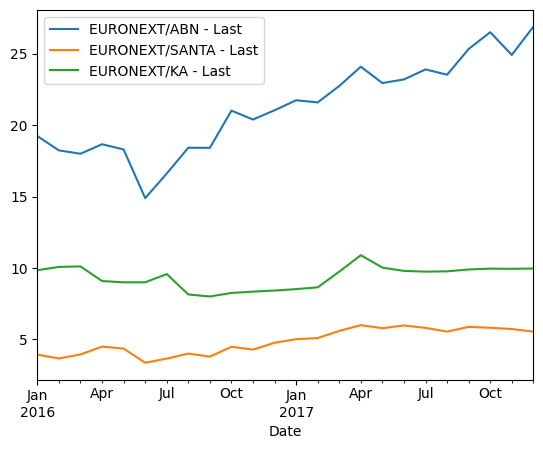

In [46]:
df.plot()

### 显示相关矩阵

In [50]:
df.pct_change().corr()
# df.pct_change().corr(method='kendall')
# df.pct_change().corr(method='spearman')

,EURONEXT/ABN - Last,EURONEXT/SANTA - Last,EURONEXT/KA - Last
EURONEXT/ABN - Last,1.000000,0.809824,0.096238
EURONEXT/SANTA - Last,0.809824,1.000000,0.058095
EURONEXT/KA - Last,0.096238,0.058095,1.000000


### 绘制相关性图

In [52]:
df = quandl.get(['EURONEXT/ABN.4', 'EURONEXT/SANTA.4'],
                start_date='2016-01-01', end_date='2017-12-31')

In [86]:
df_filled = df.asfreq('D')
daily_changes = df_filled.ffill().pct_change()
abn_returns = daily_changes['EURONEXT/ABN - Last']
santa_returns = daily_changes['EURONEXT/SANTA - Last']
window = int(len(df_filled.index)/2)
# 计算滚动相关性
df_corrs = abn_returns.rolling(window=window, min_periods=window).corr(other=santa_returns).dropna()

<Axes: xlabel='Date'>

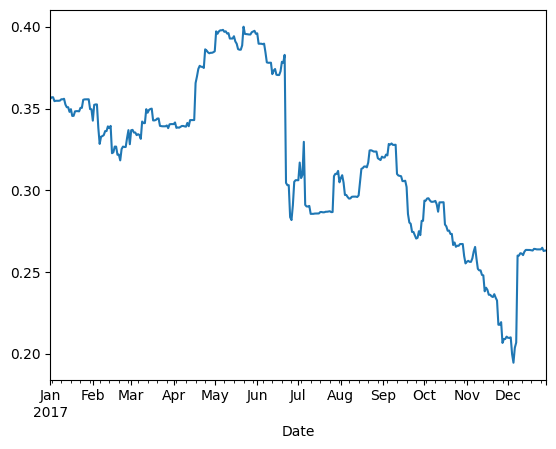

In [87]:
df_corrs.plot()

In [88]:
abn_returns.rolling(window=window, min_periods=window)

Rolling [window=363,min_periods=363,center=False,axis=0,method=single]

### 简单的移动平均线

In [96]:
import pandas as pd

In [90]:
df = quandl.get('EURONEXT/ABN.4')

In [98]:
df_filled = df.asfreq('D', method='ffill')
df_last = df['Last']

series_short = df_last.rolling(window=5, min_periods=5).mean()
series_long = df_last.rolling(window=30, min_periods=30).mean()

df_sma = pd.DataFrame({'short': series_short, 'long': series_long})

<Axes: xlabel='Date'>

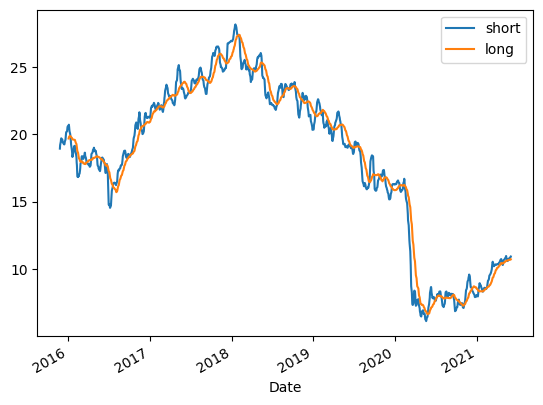

In [99]:
df_sma.plot()

### 指数移动平均

In [103]:
series_short = df_last.ewm(span=5).mean()
series_long = df_last.ewm(span=30).mean()

df_sma = pd.DataFrame({'short': series_short, 'long': series_long})

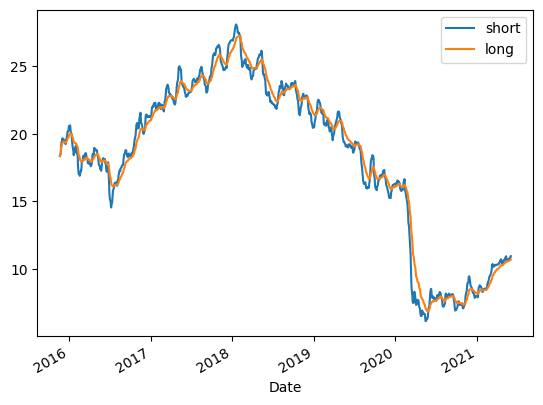

In [105]:
df_sma.plot()
plt.show()